In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import einops
from einops.layers.torch import Reduce

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)

cuda


In [3]:
#データ確認
df_train = pd.read_csv("./data/ECG/mitbih_train.csv", header = None)
df_test = pd.read_csv("./data/ECG/mitbih_test.csv", header = None)
train_size = 80000
test_size = 20000
print(df_train.shape)
print(df_test.shape)

(87554, 188)
(21892, 188)


In [4]:
#データ成形
# train_size = 20000
# test_size = 4000
# df_train = df_train[60000:]
# df_test = df_test[17000:]
# print(df_train.shape)
# print(df_test.shape)

In [5]:
#一応5種類の心電図を可視化してみる
# class_list = ["N","S","V","F","Q"]
# j = 0
# for i in range(5):
#     while True:
#         if( df_train.iloc[j][187] == i):
#             one_line = df_train.iloc[j][:186].to_list()
#             plt.plot(range(1,len(one_line)+1),one_line, label= class_list[i] )
#             plt.xlabel('ecg')
#             plt.legend()
#             plt.figure()
#             j += 1
#             break
#         else:
#             j += 1 

In [6]:
#HPパラメータ
learning_rate = 0.0002
batch_size = 64
epochs = 20
#結果保存用
history = {
    'train_loss' :[],
    'test_loss':[],
    'test_acc':[]
}

In [7]:
#訓練データセット
T = torch.FloatTensor(df_train.drop(df_train.columns[[187]], axis=1).values)
y = torch.LongTensor(df_train[187].values)
T = T.unsqueeze(1)
train_dataset = torch.utils.data.TensorDataset(T, y)

In [8]:
#テストデータセット
T = torch.FloatTensor(df_test.drop(df_test.columns[[187]], axis=1).values)
y = torch.LongTensor(df_test[187].values)
T = T.unsqueeze(1)
test_dataset = torch.utils.data.TensorDataset(T, y)

In [9]:
class LinearEmbedding(nn.Sequential):

    def __init__(self, input_channels, output_channels) -> None:
        super().__init__(*[
            nn.Linear(input_channels, output_channels),
            nn.LayerNorm(output_channels),
            nn.GELU()
        ])
        self.cls_token = nn.Parameter(torch.randn(1, output_channels))

    def forward(self, x):
        embedded = super().forward(x)
        return torch.cat([einops.repeat(self.cls_token, "n e -> b n e", b=x.shape[0]), embedded], dim=1)

In [10]:
class MLP(nn.Sequential):
    def __init__(self, input_channels, expansion=4):
        super().__init__(*[
            nn.Linear(input_channels, input_channels * expansion),
            nn.GELU(),
            nn.Linear(input_channels * expansion, input_channels)
        ])

In [11]:
class ResidualAdd(torch.nn.Module):
    def __init__(self, block):
        super().__init__()
        self.block = block

    def forward(self, x):
        return x + self.block(x)

In [12]:
#マルチヘッドアテンション
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, embed_size, num_heads, attention_store=None):
        super().__init__()
        self.queries_projection = nn.Linear(embed_size, embed_size)
        self.values_projection = nn.Linear(embed_size, embed_size)
        self.keys_projection = nn.Linear(embed_size, embed_size)
        self.final_projection = nn.Linear(embed_size, embed_size)
        self.embed_size = embed_size
        self.num_heads = num_heads

    def forward(self, x):
        assert len(x.shape) == 3
        keys = self.keys_projection(x)
        values = self.values_projection(x)
        queries = self.queries_projection(x)
        keys = einops.rearrange(keys, "b n (h e) -> b n h e", h=self.num_heads)
        queries = einops.rearrange(queries, "b n (h e) -> b n h e", h=self.num_heads)
        values = einops.rearrange(values, "b n (h e) -> b n h e", h=self.num_heads)
        energy_term = torch.einsum("bqhe, bkhe -> bqhk", queries, keys)
        divider = np.sqrt(self.embed_size)
        mh_out = torch.softmax(energy_term, -1)
        out = torch.einsum('bihv, bvhd -> bihd ', mh_out / divider, values)
        out = einops.rearrange(out, "b n h e -> b n (h e)")
        return self.final_projection(out)

In [13]:
class TransformerEncoderLayer(torch.nn.Sequential):
    def __init__(self, embed_size, expansion, num_heads, dropout = 0.1):
        super(TransformerEncoderLayer, self).__init__(
            *[
                ResidualAdd(nn.Sequential(*[
                    nn.LayerNorm(embed_size),
                    MultiHeadAttention(embed_size, num_heads),
                    nn.Dropout(dropout)
                ])),
                ResidualAdd(nn.Sequential(*[
                    nn.LayerNorm(embed_size),
                    MLP(embed_size, expansion),
                    nn.Dropout(dropout)
                ]))
            ]
        )
    
    def forward(self,x):
        return super().forward(x)

In [14]:
class Classifier(nn.Sequential):
    def __init__(self, embed_size, num_classes):
        super().__init__(*[
            Reduce("b n e -> b e", reduction="mean"),
            nn.Linear(embed_size, embed_size),
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, num_classes)
        ])

In [15]:
class ECGformer(nn.Module):

    def __init__(self, num_layers, signal_length, num_classes, input_channels, embed_size, num_heads, expansion) -> None:
        super().__init__()
        self.encoder = nn.ModuleList([TransformerEncoderLayer(
            embed_size=embed_size, num_heads=num_heads, expansion=expansion) for _ in range(num_layers)])
        self.classifier = Classifier(embed_size, num_classes)
        self.positional_encoding = nn.Parameter(torch.randn(signal_length + 1 , embed_size))
        self.embedding = LinearEmbedding(input_channels, embed_size)

    def forward(self, x):
        embedded = self.embedding(x)
        x = embedded + self.positional_encoding
        for i in self.encoder:
            x = i(x)
        return self.classifier(x)

In [16]:
#モデル生成・データロード
from torchsummary import summary
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
num_layers: int = 6
signal_length: int = 187
num_classes: int = 5
input_channels: int = 1
embed_size: int = 192
num_heads: int = 8
expansion: int = 4
model = ECGformer(num_layers, signal_length, num_classes, input_channels, embed_size, num_heads, expansion)
print(model)

#損失関数，最適化
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.1, 0.4, 0.2, 0.5, 0.2]))
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

ECGformer(
  (encoder): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (0): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (queries_projection): Linear(in_features=192, out_features=192, bias=True)
            (values_projection): Linear(in_features=192, out_features=192, bias=True)
            (keys_projection): Linear(in_features=192, out_features=192, bias=True)
            (final_projection): Linear(in_features=192, out_features=192, bias=True)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MLP(
            (0): Linear(in_features=192, out_features=768, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=768, out_features=192, bias=True)
          )
          (2):

In [17]:
cnt = 0
for data in train_dataloader:
    print(data[0].shape, type(data[0]))
    print(data[1])
    print("=========")
    cnt += 1
    if cnt==3:
        break
        
print(len(test_dataloader)*64)

torch.Size([64, 1, 187]) <class 'torch.Tensor'>
tensor([0, 0, 0, 4, 2, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 4, 0, 4, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4])
torch.Size([64, 1, 187]) <class 'torch.Tensor'>
tensor([0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 2, 0,
        0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0])
torch.Size([64, 1, 187]) <class 'torch.Tensor'>
tensor([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 4, 0, 2, 0, 0, 0, 4, 0, 0, 4, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2])
21952


In [18]:
#学習ループ
def train_loop(dataloader,model, loss_fn, optimizer):
    #size = len(dataloader.dataset)
    size = train_size
    num_batches = len(dataloader)
    model.train()
    sum_loss, avg_loss, correct = 0, 0, 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(einops.rearrange(X, "b c e -> b e c"))
        loss = loss_fn(pred, y)
        sum_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # 逆伝播
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 64 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print("予測")
            print(pred.argmax(1))
            print("正解")
            print(y)
            print("現在の正解数")
            print(correct)
            #print(pred)
            
            
    avg_loss = sum_loss / num_batches
    history['train_loss'].append(avg_loss)

In [19]:
#評価ループ
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    i = 1
    test_loss, correct = 0, 0
    finished = 0
    
    with torch.no_grad():
        for X,y in dataloader:
            pred = model(einops.rearrange(X, "b c e -> b e c"))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if( i % 100 == 0):
                print("予測")
                print(pred.argmax(1))
                print("正解")
                print(y)
                print("--------------------------------------")
            i += 1

    test_loss /= num_batches
    print(correct)
    acc = correct / size
    print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    history['test_loss'].append(test_loss)
    history['test_acc'].append(acc)

In [20]:
#学習・評価
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.784803  [   64/80000]
予測
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
正解
tensor([0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 2, 0, 4, 2, 1, 0, 0, 0, 0, 0, 0, 3, 3])
現在の正解数
2.0
loss: 1.183538  [ 4160/80000]
予測
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
正解
tensor([0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 2, 0, 4, 0,
        2, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
現在の正解数
33

{'train_loss': [0.4783917855542123, 0.2744889927332727, 0.2446274281696432, 0.2186508975008746, 0.20508389077247974, 0.19486164466265, 0.1819604485723618, 0.1717462306141505, 0.1622415617233519, 0.15527276864644055, 0.14809121661856933, 0.1419405079963076, 0.1421176235873859, 0.13333320497875997, 0.13248231088323553, 0.12877543486054058, 0.12179970513305431, 0.11984189024597809, 0.11845498414059803, 0.11321470630916422], 'test_loss': [0.3150600533085297, 0.28034223510772427, 0.24516158096448848, 0.2912319901510639, 0.23603639129342907, 0.2074437805671386, 0.2415736774281319, 0.24544534789881622, 0.20168824475693026, 0.1768690902066387, 0.1887226287674691, 0.17190348180336743, 0.1876044302755212, 0.1910123120526357, 0.19187156757904603, 0.17579714469231514, 0.1617300611467212, 0.1626914635140438, 0.1674148505947311, 0.17264587876357074], 'test_acc': [0.9550977526036909, 0.9415768317193496, 0.9585236616115476, 0.9571076192216335, 0.9608532797368902, 0.9650557281198612, 0.9312991046957793

Text(0.5, 0, 'epoch')

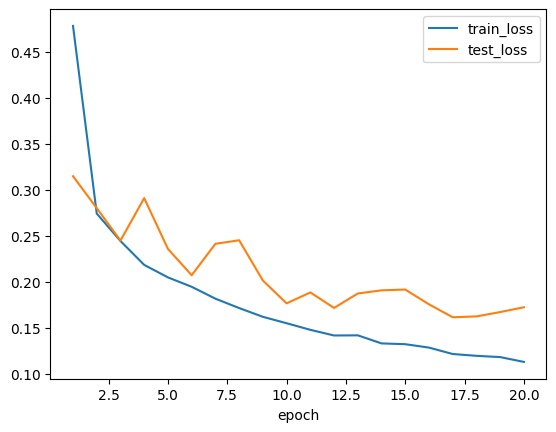

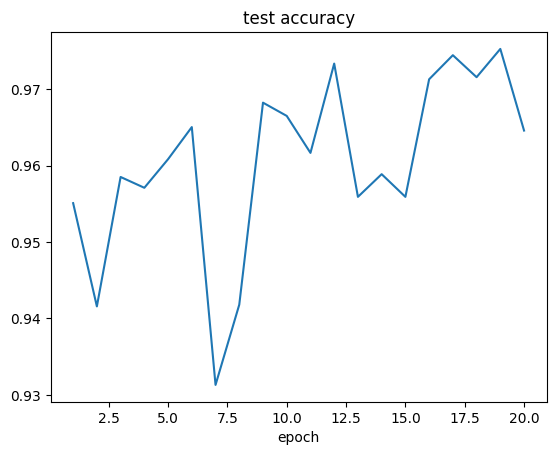

In [21]:
print(history)
plt.plot(range(1, epochs+1), history['train_loss'], label='train_loss')
plt.plot(range(1, epochs+1), history['test_loss'], label='test_loss')
plt.xlabel('epoch')
plt.legend()
 
plt.figure()
plt.plot(range(1, epochs+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')